In [14]:
import json
from datetime import datetime, timezone
import time
import numpy as np
import codecs
import struct
import matplotlib.pyplot as plt
import pandas as pd
import pathlib
import pickle

%matplotlib inline

"""
import firebase_admin
from firebase_admin import credentials
from firebase_admin import firestore

cred = credentials.Certificate("../watchv1app-firebase-adminsdk-nzb87-8083b2ff94.json")
firebase_admin.initialize_app(cred)

db = firestore.client()

conditions_ref = db.collection(u'conditions')
events_ref = db.collection(u'events')
"""

'\nimport firebase_admin\nfrom firebase_admin import credentials\nfrom firebase_admin import firestore\n\ncred = credentials.Certificate("../watchv1app-firebase-adminsdk-nzb87-8083b2ff94.json")\nfirebase_admin.initialize_app(cred)\n\ndb = firestore.client()\n\nconditions_ref = db.collection(u\'conditions\')\nevents_ref = db.collection(u\'events\')\n'

In [140]:
f = open('../watchData.json',)
data = json.load(f)
f.close()

local_tz = datetime.now().astimezone().tzinfo
real_data = []

for k in data:
    label = ""
    if 'label' in data[k]: label = data[k]['label']
    real_data.append({
        'timestamp': datetime.fromtimestamp(data[k]['timestamp']['value']['_seconds']).astimezone(local_tz), 
        'type': data[k]['type'],
        'data': data[k]['data'],
        'uid' : data[k]['uid'][:3],
        'label': label
    })
    
data = sorted(real_data, key=lambda k: k['timestamp'])
del real_data

In [141]:
def tsToStr(ts): return ts.strftime("%m/%d/%y %I:%M:%S%p %Z")

def print_data_from_day(day='03/25'):
    return_data = []
    for entry in data:
        datestring = tsToStr(entry['timestamp'])
        if (datestring[0:5] == day):
            if label == "":
                print(datestring, ' | ', entry['type'], ' | ', entry['data'])
            else:
                print(datestring, ' | ', entry['type'], ' | ', entry['data'], ' | ', entry['label'])
            
            return_data.append(entry)
            
    return return_data

def print_data_from_day_without_survey(day='03/25'):
    local_tz = datetime.now().astimezone().tzinfo
    return_data = []
    for entry in data:
        datestring = tsToStr(entry['timestamp'])
        if (datestring[0:5] == day and entry['type'] not in ['TX_SURVEY_RESULT', 'TX_SURVEY_INITIALIZED']):
            
            if entry['type'] == 'TX_TIME_SEEN':
                s = entry['data'][2:]
                datastring = s[6:8] + ':' + s[8:10]
            else:
                datastring = entry['data']
            if label == "":
                print(datestring, ' | ', "{:<17}".format(entry['type'][3:]), ' | ', datastring)
            else:
                print(datestring, ' | ', "{:<17}".format(entry['type'][3:]), ' | ', datastring, ' | ', entry['label'])
            
            return_data.append(entry)
            
    return return_data


def get_timeest_error(entry):
    #Return error in minutes from a time_est entry
    real_time = entry['timestamp']
    
    guess_time = entry['timestamp'].replace(
        hour=int(entry['data'].split(':')[0]), 
        minute=int(entry['data'].split(':')[1])
    )
    
    if real_time > guess_time:
        return -1*int((real_time-guess_time).seconds/60)
    else:
        return int((guess_time-real_time).seconds/60)
    
    
def get_estimates(daydata):
    #every 'TIME_EST' get error, duration since immediate previous
    #if immediate previous is time_seen
    return_data = []
    for i in range(1, len(daydata)):
        if daydata[i]['type']=='TX_TIME_EST' and daydata[i-1]['type']=='TX_TIME_SEEN':
            
            error = get_timeest_error(daydata[i])
            interval = int((daydata[i]['timestamp']-daydata[i-1]['timestamp']).seconds/60)
            intervalstring = tsToStr(daydata[i-1]['timestamp'])[0:14] + '-' + tsToStr(daydata[i]['timestamp'])[9:14]
            eve = True if int(daydata[i-1]['timestamp'].strftime('%H')) >= 17 else False
            evestring = ' | eve' if eve else ''
            
            if interval > 5:
                print(intervalstring + ' | interval: ' + str(interval) + ' | error: ' + str(error) + evestring)
            
                return_data.append({
                    'interval_string' : intervalstring,
                    'evening' : eve,
                    'interval': interval,
                    'error': error,
                    'abs_error': abs(error)
                })
            
    return return_data

#daydata = print_data_from_day()

daydata = print_data_from_day_without_survey()
print ('---')
estimates = get_estimates(daydata)
print('---')
print(estimates)

03/25/21 10:11:46AM EDT  |  TIMESTAMP_UPDATE   |  -3
03/25/21 10:25:01AM EDT  |  TIME_EST           |  10:20
03/25/21 10:25:59AM EDT  |  TIME_SEEN          |  10:25
03/25/21 11:55:34AM EDT  |  TIME_EST           |  11:14
03/25/21 11:56:22AM EDT  |  TIME_SEEN          |  11:56
03/25/21 01:11:38PM EDT  |  TIME_EST           |  12:27
03/25/21 01:13:01PM EDT  |  TIME_SEEN          |  13:13
03/25/21 01:28:19PM EDT  |  TIME_EST           |  13:40
03/25/21 01:28:20PM EDT  |  TIME_SEEN          |  13:28
03/25/21 02:49:54PM EDT  |  TIME_EST           |  14:37
03/25/21 02:50:33PM EDT  |  TIME_SEEN          |  14:50
03/25/21 03:09:28PM EDT  |  PREVIOUS_INVALID   |  
03/25/21 03:09:31PM EDT  |  TIME_SEEN          |  15:09
03/25/21 03:52:33PM EDT  |  TIME_EST           |  15:36
03/25/21 03:52:34PM EDT  |  TIME_SEEN          |  15:52
03/25/21 03:52:34PM EDT  |  PREVIOUS_INVALID   |  
03/25/21 04:44:13PM EDT  |  TIME_EST           |  16:4
03/25/21 04:45:04PM EDT  |  TIME_SEEN          |  16:45
03/25/

In [142]:
video_metadata = {
'david_2'  : {'date': '03/25', 'vid_start': '03/25/21 01:41:01PM EDT'},      
'patrick_1': {'date': '03/29', 'vid_start': '03/29/21 03:28:19PM EDT'},
'patrick_2': {'date': '04/01', 'vid_start': '04/01/21 02:35:31PM EDT'},
'beata_1'  : {'date': '04/02', 'vid_start': '04/02/21 12:16:30PM EDT'},
'david_3b' : {'date': '04/06', 'vid_start': '04/06/21 04:48:22PM EDT'},
'irmandy_1': {'date': '04/08', 'vid_start': '04/08/21 05:30:56PM EDT'},
'juliana_1': {'date': '04/09', 'vid_start': '04/09/21 10:21:33AM EDT'},
'irmandy_2': {'date': '04/16', 'vid_start': '04/16/21 05:35:15PM EDT'},
'patrick_3': {'date': '04/28', 'vid_start': '04/28/21 01:10:00PM EDT'},
}

In [143]:
daydata = print_data_from_day_without_survey('04/09')
print ('---')
e0 = get_estimates(daydata)

04/09/21 10:00:16AM EDT  |  BEGIN_PAUSE        |  
04/09/21 10:18:10AM EDT  |  TIMESTAMP_UPDATE   |  -1
04/09/21 10:18:25AM EDT  |  BEGIN_PAUSE        |  
04/09/21 10:18:27AM EDT  |  TIME_SEEN          |  10:18
04/09/21 10:18:34AM EDT  |  BEGIN_PAUSE        |  
04/09/21 10:18:50AM EDT  |  BEGIN_PAUSE        |  
04/09/21 10:19:04AM EDT  |  PREVIOUS_INVALID   |  
04/09/21 10:19:05AM EDT  |  TIME_SEEN          |  10:19
04/09/21 10:22:36AM EDT  |  TIME_EST           |  12:0
04/09/21 10:22:37AM EDT  |  TIME_SEEN          |  10:22
04/09/21 10:22:54AM EDT  |  PREVIOUS_INVALID   |  
04/09/21 10:22:58AM EDT  |  TIME_SEEN          |  10:22
04/09/21 10:27:59AM EDT  |  TIME_EST           |  9:52
04/09/21 10:28:00AM EDT  |  TIME_SEEN          |  10:28
04/09/21 10:28:12AM EDT  |  TIME_EST           |  10:31
04/09/21 10:28:13AM EDT  |  TIME_SEEN          |  10:28
04/09/21 10:28:21AM EDT  |  PREVIOUS_INVALID   |  
04/09/21 10:28:21AM EDT  |  PREVIOUS_INVALID   |  
04/09/21 10:28:22AM EDT  |  TIME_SEEN

In [144]:
daydata = print_data_from_day_without_survey('04/08')
print ('---')
irmandy1_estimates = get_estimates(daydata)

daydata = print_data_from_day_without_survey('04/16')
print ('---')
irmandy2_estimates = get_estimates(daydata)

e1 = irmandy1_estimates + irmandy2_estimates

04/08/21 05:26:24PM EDT  |  TIMESTAMP_UPDATE   |  -2311
04/08/21 05:27:32PM EDT  |  TIME_EST           |  15:18
04/08/21 05:29:05PM EDT  |  TIME_SEEN          |  17:29
04/08/21 05:29:23PM EDT  |  TIME_EST           |  17:58
04/08/21 05:29:24PM EDT  |  TIME_SEEN          |  17:29
04/08/21 05:29:30PM EDT  |  TIME_EST           |  17:15
04/08/21 05:29:32PM EDT  |  TIME_SEEN          |  17:29
04/08/21 05:29:38PM EDT  |  PREVIOUS_INVALID   |  
04/08/21 05:29:42PM EDT  |  TIME_SEEN          |  17:29
04/08/21 05:29:56PM EDT  |  TIME_EST           |  17:30
04/08/21 05:29:57PM EDT  |  TIME_SEEN          |  17:29
04/08/21 05:30:10PM EDT  |  TIME_EST           |  17:8
04/08/21 05:30:11PM EDT  |  TIME_SEEN          |  17:30
04/08/21 05:30:31PM EDT  |  TIME_EST           |  16:28
04/08/21 05:30:32PM EDT  |  TIME_SEEN          |  17:30
04/08/21 05:30:41PM EDT  |  TIME_EST           |  17:26
04/08/21 05:30:42PM EDT  |  TIME_SEEN          |  17:30
04/08/21 05:30:50PM EDT  |  TIME_EST           |  17:0

In [145]:
daydata = print_data_from_day_without_survey('04/02')
print ('---')
e2 = get_estimates(daydata)

04/02/21 12:11:37PM EDT  |  TIMESTAMP_UPDATE   |  397
04/02/21 12:17:55PM EDT  |  TIME_SEEN          |  12:17
04/02/21 12:18:17PM EDT  |  TIME_EST           |  11:51
04/02/21 12:18:19PM EDT  |  TIME_SEEN          |  12:18
04/02/21 12:58:28PM EDT  |  TIME_EST           |  12:30
04/02/21 01:00:17PM EDT  |  TIME_SEEN          |  13:00
04/02/21 01:36:30PM EDT  |  TIMESTAMP_UPDATE   |  0
04/02/21 01:37:11PM EDT  |  TIME_SEEN          |  13:37
04/02/21 02:16:25PM EDT  |  TIME_EST           |  14:15
04/02/21 02:17:20PM EDT  |  TIME_SEEN          |  14:17
04/02/21 03:00:29PM EDT  |  TIME_EST           |  14:30
04/02/21 03:01:33PM EDT  |  TIME_SEEN          |  15:01
04/02/21 03:35:50PM EDT  |  TIME_EST           |  15:33
04/02/21 03:36:48PM EDT  |  TIME_SEEN          |  15:36
04/02/21 04:09:26PM EDT  |  TIME_EST           |  16:0
04/02/21 04:10:13PM EDT  |  TIME_SEEN          |  16:10
04/02/21 04:37:22PM EDT  |  TIME_EST           |  16:31
04/02/21 04:38:14PM EDT  |  TIME_SEEN          |  16:38

In [146]:
daydata = print_data_from_day_without_survey('03/29')
print ('---')
patrick1_estimates = get_estimates(daydata)

daydata = print_data_from_day_without_survey('04/01')
print ('---')
patrick2_estimates = get_estimates(daydata)

daydata = print_data_from_day_without_survey('04/28')
print ('---')
patrick3_estimates = get_estimates(daydata)

e3 = patrick1_estimates + patrick2_estimates + patrick3_estimates
print(e3)

03/29/21 02:05:41PM EDT  |  TIMESTAMP_UPDATE   |  7467
03/29/21 02:05:59PM EDT  |  PREVIOUS_INVALID   |  
03/29/21 02:06:00PM EDT  |  TIME_SEEN          |  14:06
03/29/21 03:02:54PM EDT  |  TIMESTAMP_UPDATE   |  10989
03/29/21 03:03:24PM EDT  |  PREVIOUS_INVALID   |  
03/29/21 03:03:25PM EDT  |  TIME_SEEN          |  15:03
03/29/21 03:32:52PM EDT  |  TIMESTAMP_UPDATE   |  0
03/29/21 03:33:59PM EDT  |  TIME_SEEN          |  15:33
03/29/21 04:04:54PM EDT  |  TIMESTAMP_UPDATE   |  1
03/29/21 04:05:30PM EDT  |  TIME_SEEN          |  16:05
03/29/21 04:45:21PM EDT  |  TIME_EST           |  16:17
03/29/21 04:46:15PM EDT  |  TIME_SEEN          |  16:46
03/29/21 05:30:22PM EDT  |  TIME_EST           |  17:14
03/29/21 05:31:09PM EDT  |  TIME_SEEN          |  17:31
03/29/21 06:06:31PM EDT  |  TIME_EST           |  18:12
03/29/21 06:07:24PM EDT  |  TIME_SEEN          |  18:07
03/29/21 06:47:17PM EDT  |  TIME_EST           |  18:47
03/29/21 06:48:07PM EDT  |  TIME_SEEN          |  18:48
03/29/21 06

In [147]:
daydata = print_data_from_day_without_survey('03/25')
print ('---')
e4 = get_estimates(daydata)

03/25/21 10:11:46AM EDT  |  TIMESTAMP_UPDATE   |  -3
03/25/21 10:25:01AM EDT  |  TIME_EST           |  10:20
03/25/21 10:25:59AM EDT  |  TIME_SEEN          |  10:25
03/25/21 11:55:34AM EDT  |  TIME_EST           |  11:14
03/25/21 11:56:22AM EDT  |  TIME_SEEN          |  11:56
03/25/21 01:11:38PM EDT  |  TIME_EST           |  12:27
03/25/21 01:13:01PM EDT  |  TIME_SEEN          |  13:13
03/25/21 01:28:19PM EDT  |  TIME_EST           |  13:40
03/25/21 01:28:20PM EDT  |  TIME_SEEN          |  13:28
03/25/21 02:49:54PM EDT  |  TIME_EST           |  14:37
03/25/21 02:50:33PM EDT  |  TIME_SEEN          |  14:50
03/25/21 03:09:28PM EDT  |  PREVIOUS_INVALID   |  
03/25/21 03:09:31PM EDT  |  TIME_SEEN          |  15:09
03/25/21 03:52:33PM EDT  |  TIME_EST           |  15:36
03/25/21 03:52:34PM EDT  |  TIME_SEEN          |  15:52
03/25/21 03:52:34PM EDT  |  PREVIOUS_INVALID   |  
03/25/21 04:44:13PM EDT  |  TIME_EST           |  16:4
03/25/21 04:45:04PM EDT  |  TIME_SEEN          |  16:45
03/25/

In [148]:
def print_data_from_day_without_survey(data):
    local_tz = datetime.now().astimezone().tzinfo
    for entry in data:
        datestring = tsToStr(entry['timestamp'])
        if (entry['type'] not in ['TX_SURVEY_RESULT', 'TX_SURVEY_INITIALIZED']):
            
            if entry['type'] == 'TX_TIME_SEEN':
                s = entry['data'][2:]
                datastring = s[6:8] + ':' + s[8:10]
            else:
                datastring = entry['data']
            
            print(datestring, ' | ', "{:<17}".format(entry['type'][3:]), ' | ', datastring)

In [149]:
golfing_data = []
for entry in data:
    if (entry['label'] == 'golfing'):
        golfing_data.append(entry)

print_data_from_day_without_survey(golfing_data)
golf_estimates = get_estimates(golfing_data)

09/26/21 01:48:48PM EDT  |  PREVIOUS_INVALID   |  
09/26/21 01:48:49PM EDT  |  TIME_SEEN          |  13:48
09/26/21 01:59:01PM EDT  |  TIME_EST           |  13:34
09/26/21 02:10:47PM EDT  |  PREVIOUS_INVALID   |  
09/26/21 02:10:48PM EDT  |  TIME_SEEN          |  14:10
09/26/21 02:10:54PM EDT  |  PREVIOUS_INVALID   |  
09/26/21 02:10:55PM EDT  |  TIME_SEEN          |  14:10
09/26/21 02:11:05PM EDT  |  PREVIOUS_INVALID   |  
09/26/21 02:11:08PM EDT  |  TIME_SEEN          |  14:11
09/26/21 02:11:24PM EDT  |  TIME_EST           |  0:23
09/26/21 02:28:29PM EDT  |  TIMESTAMP_UPDATE   |  1
09/26/21 02:39:56PM EDT  |  PREVIOUS_INVALID   |  
09/26/21 02:39:57PM EDT  |  TIME_SEEN          |  14:39
09/26/21 02:40:13PM EDT  |  TIME_EST           |  0:33
09/26/21 02:48:47PM EDT  |  TIMESTAMP_UPDATE   |  0
09/26/21 02:54:13PM EDT  |  PREVIOUS_INVALID   |  
09/26/21 02:54:14PM EDT  |  TIME_SEEN          |  14:54
09/26/21 02:54:22PM EDT  |  PREVIOUS_INVALID   |  
09/26/21 02:54:26PM EDT  |  TIME_SEEN

In [150]:
## GOLFING took place Sept 26, starting at 1:48
nathan = {
    'seen': '1:48',
    'dur_1': 17,
    'dur_1_uncertainty': 7,
    'dur_2': 25,
    'dur_2_uncertainty': 10,
    'dur_3': 30,
    'dur_4': 35, -- potentially me
    'seen': '3:41',
    'dur_6': 30,'4:15' --could be durations
    'seen': '4:16'
    'dur_7' 25, '5:02' --could be duration
    
}

sam = {
    'seen': '1:48',
    'dur_1' : 20,
    'dur_1_uncertainty': 5,
    'dur_2': 30,
    'dur_2_uncertainty': 10,
    'time_3': '2:10',
    'time_3_uncertainty': 10,
    'time_4': '3:10',
    'time_4_uncertainty': 20,
    'seen': '3:41',
    'dur_5' : 65,
    'time_6': '4:20', 
    'seen': '4:16',
    'time_6_uncertainty': 10 --could be duration
}

david = {
    '3:50' --potentially nathan
}

## first two durations are solid

3:50 - 4:16 '4:15'
4:38 - 4:53 '5:02'
            
1:48 - 1:59 '2:10'
1:48 - 3:39 '3:10'
3:41 - 4:16 '4:20'

SyntaxError: invalid syntax (<ipython-input-150-fbd377d29c42>, line 9)

In [151]:
e5 = [{'interval_string': '09/26/21 01:48-01:59', 'evening': False, 'interval': 11, 'error': 11, 'abs_error': 11}, 
      {'interval_string': '09/26/21 01:48-03:39', 'evening': False, 'interval': 111, 'error': -29, 'abs_error': 29}, 
      {'interval_string': '09/26/21 03:41-04:16', 'evening': False, 'interval': 35, 'error': 4, 'abs_error': 4} 
    ]

e6 = [{'interval_string': '09/26/21 03:50-04:16', 'evening': False, 'interval': 26, 'error': -1, 'abs_error': 1}, 
      {'interval_string': '09/26/21 03:50-04:53', 'evening': False, 'interval': 63, 'error': 9, 'abs_error': 9}
    ]

In [152]:
def flatten(t): return [item for sublist in t for item in sublist]

es = [e0,e1,e2,e3,e4,e5,e6]
flat_es = flatten(es)

flat_es2 = []

for entry in flat_es:
    e = entry.copy()
    if e['error'] < -40 and e['interval'] < 45:
        print(e)
        e['error'] += 60
        e['abs_error'] += 60
        
        print(e)
    flat_es2.append(e)

{'interval_string': '04/09/21 10:53-11:12', 'evening': False, 'interval': 18, 'error': -77, 'abs_error': 77}
{'interval_string': '04/09/21 10:53-11:12', 'evening': False, 'interval': 18, 'error': -17, 'abs_error': 137}
{'interval_string': '04/09/21 12:42-12:59', 'evening': False, 'interval': 16, 'error': -71, 'abs_error': 71}
{'interval_string': '04/09/21 12:42-12:59', 'evening': False, 'interval': 16, 'error': -11, 'abs_error': 131}
{'interval_string': '04/09/21 02:24-02:40', 'evening': False, 'interval': 16, 'error': -82, 'abs_error': 82}
{'interval_string': '04/09/21 02:24-02:40', 'evening': False, 'interval': 16, 'error': -22, 'abs_error': 142}
{'interval_string': '04/09/21 02:41-02:55', 'evening': False, 'interval': 13, 'error': -61, 'abs_error': 61}
{'interval_string': '04/09/21 02:41-02:55', 'evening': False, 'interval': 13, 'error': -1, 'abs_error': 121}
{'interval_string': '04/09/21 02:55-03:03', 'evening': False, 'interval': 7, 'error': -70, 'abs_error': 70}
{'interval_string

In [153]:
print(len(flat_es))

57


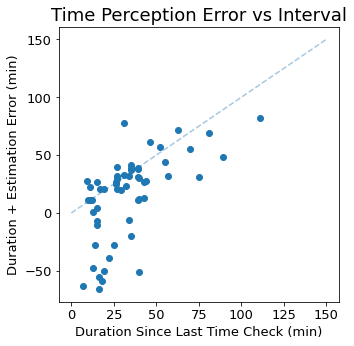

In [165]:
plt.rcParams.update({'font.size': 13})
def plot_errors(es):
    fig, ax = plt.subplots(figsize=(5,5))
    
    xs, ys = [], []
    for entry in es:
        xs.append(entry['interval'])
        ys.append(entry['interval'] + entry['error'])
    plt.scatter(xs, ys)
    ax.set(xlabel='Duration Since Last Time Check (min)')
    ax.set(ylabel='Duration + Estimation Error (min)')
    plt.plot([0,150],[0,150], '--', alpha=0.4)
    plt.title('Time Perception Error vs Interval', fontsize=18)
    plt.tight_layout()
    
    plt.savefig('time_perception_error', dpi=300)
    plt.show()
    
plot_errors(flat_es)
#plot_errors(flat_es2)

In [175]:
# n = 7 for watch
# n = 7 for buzz - david, patrick, caroline, irmandy,  [fangzheng, ishwarya, one other person]
times, errors = [], []

for entry in flat_es:
    times.append(entry['interval'])
    errors.append(entry['error'])
    
print(sum(times))
print(np.mean(times))
print(sum([abs(e) for e in errors]))
print(np.mean(errors))
print(min(times))
print(max(times))

1908
33.473684210526315
1344
-17.964912280701753
7
111


In [168]:
1908/60

31.8

In [177]:
errors_clean = []
for entry in flat_es:
    if entry['interval'] > entry['abs_error']:
        errors_clean.append(entry['error'])

print(np.mean(errors_clean))
print(np.mean([abs(e) for e in errors_clean]))

-7.05
11.2


In [178]:
for e in es:
    print('person')
    for entry in e:
        if entry['interval'] < entry['abs_error']:
            print(entry)

person
{'interval_string': '04/09/21 10:53-11:12', 'evening': False, 'interval': 18, 'error': -77, 'abs_error': 77}
{'interval_string': '04/09/21 12:42-12:59', 'evening': False, 'interval': 16, 'error': -71, 'abs_error': 71}
{'interval_string': '04/09/21 01:18-01:27', 'evening': False, 'interval': 9, 'error': 19, 'abs_error': 19}
{'interval_string': '04/09/21 02:24-02:40', 'evening': False, 'interval': 16, 'error': -82, 'abs_error': 82}
{'interval_string': '04/09/21 02:41-02:55', 'evening': False, 'interval': 13, 'error': -61, 'abs_error': 61}
{'interval_string': '04/09/21 02:55-03:03', 'evening': False, 'interval': 7, 'error': -70, 'abs_error': 70}
{'interval_string': '04/09/21 03:49-04:09', 'evening': False, 'interval': 19, 'error': -69, 'abs_error': 69}
person
{'interval_string': '04/08/21 09:27-09:53', 'evening': True, 'interval': 25, 'error': -53, 'abs_error': 53}
{'interval_string': '04/08/21 10:26-10:40', 'evening': True, 'interval': 14, 'error': -42, 'abs_error': 42}
{'interval

In [190]:
times_eve, errors_eve = [], []
times_day, errors_day = [], []

for entry in flat_es:
    if entry['interval'] > entry['abs_error']:
        if entry['evening']:
            errors_eve.append(entry['error'])
            times_eve.append(entry['interval'])
        else:
            errors_day.append(entry['error'])
            times_day.append(entry['interval'])

In [191]:
print(len(times_eve))
print(len(times_day))

13
27


In [192]:
print(np.mean([abs(e) for e in errors_eve]))
print(np.mean([abs(e) for e in errors_day]))

6.615384615384615
13.407407407407407


In [193]:
es_fixed_offbyhour = []

for entry in flat_es:
    if entry['interval'] < entry['abs_error'] and entry['abs_error'] >40:
        new_e = entry.copy()
        
        if entry['error'] < 0:
            new_e['error'] +=60
        else:
            new_e['error'] -=60
        
        new_e['abs_error'] = abs(new_e['error'])
        
        es_fixed_offbyhour.append(new_e)    
    else:
        es_fixed_offbyhour.append(entry)

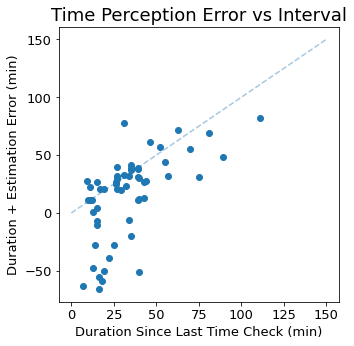

In [194]:
plot_errors(flat_es)

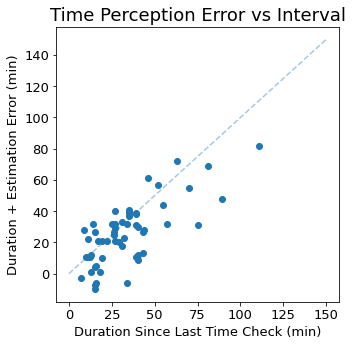

In [195]:
plot_errors(es_fixed_offbyhour)

In [206]:
times_eve, errors_eve = [], []
times_day, errors_day = [], []

for entry in es_fixed_offbyhour:
    if entry['evening']:
        errors_eve.append(entry['error'])
        times_eve.append(entry['interval'])
    else:
        errors_day.append(entry['error'])
        times_day.append(entry['interval'])

In [207]:
print(len(times_eve))
print(len(times_day))

21
36


In [209]:
print(np.mean([abs(e)/t for e,t in zip(errors_eve, times_eve)]))
print(np.mean([abs(e)/t for e,t in zip(errors_day, times_day)]))

print(np.mean([abs(e) for e,t in zip(errors_eve, times_eve)]))
print(np.mean([abs(e) for e,t in zip(errors_day, times_day)]))

print(np.std([abs(e) for e,t in zip(errors_eve, times_eve)]))
print(np.std([abs(e) for e,t in zip(errors_day, times_day)]))



0.3856323633172539
0.5150547235810516
10.761904761904763
13.444444444444445
10.857978246891882
10.958113291693067


In [213]:
print(np.mean(times_eve))
print(np.mean(times_day))

31.047619047619047
34.888888888888886


In [200]:
print(np.mean(errors_eve))
print(np.mean(errors_day))


-2.4838709677419355
-9.620689655172415


In [212]:
times, errors = [], []

for entry in es_fixed_offbyhour:
    times.append(entry['interval'])
    errors.append(entry['error'])
    
print(sum(times))
print(np.mean(times))
print(sum([abs(e) for e in errors]))
print(np.mean([abs(e) for e in errors]))
print(np.mean(errors))
print(min(times))
print(max(times))

1908
33.473684210526315
710
12.456140350877194
-7.43859649122807
7
111
